In [1]:
import yfinance 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
ticker = 'AAPL'
df = yfinance.download(ticker)
open_values = df.iloc[:, 0:1].values
len(open_values)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15,0.093678,0.094108,0.093678,0.094108,175884800
1980-12-16,0.086802,0.087232,0.086802,0.087232,105728000
1980-12-17,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18,0.091530,0.091959,0.091530,0.091530,73449600
...,...,...,...,...,...
2024-12-19,249.789993,252.000000,247.089996,247.500000,60882300
2024-12-20,254.490005,255.000000,245.690002,248.039993,147495300


In [3]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))
open_values = mms.fit_transform(open_values)
open_values

array([[2.35613082e-04],
       [2.15703415e-04],
       [1.89154162e-04],
       ...,
       [9.85520298e-01],
       [9.96833848e-01],
       [1.00000000e+00]])

Take the previous 100 timesteps into one array and make X_train and y_train based off such values.

In [4]:
X_train = []
y_train = []
marker = int(.8 * len(open_values))
for i in range(100, marker):
  X_train.append(open_values[i-100:i, 0])
  y_train.append(open_values[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# change it to a 3D tensor

X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
X_train.shape

(8781, 100, 1)

In [5]:
class LSTM():
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    self.model = None
  
  def check(self):
    return self.model.summary
  
  def create_model(self):
    model = tf.keras.models.Sequential(
      layers=[
        tf.keras.layers.Input(shape=(self.x_train.shape[1], 1)),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(units=1)
      ] 
    )

    self.model = model
  
  def compile(self):
    self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=[])
    return self.model.fit(self.x_train, self.y_train, epochs=3, batch_size=500)
  
  def predict(self, x_test):
    return self.model.predict(x_test)
    

In [6]:
model = LSTM(X_train, y_train)
model.create_model()
model.compile()
model.model.save('../models/lstm.keras')

Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step - loss: 5.3263e-04
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - loss: 5.3897e-05
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - loss: 1.5759e-05


create testing dataset

In [7]:
X_test = []
y_truth = []

dataset_total = df['Open']
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = mms.transform(inputs)

for i in range(marker, len(dataset_total)):
  X_test.append(inputs[i-100:i, 0])
  y_truth.append(inputs[i, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_truth = np.array(y_truth).reshape(-1, 1) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)
y_truth = mms.inverse_transform(y_truth)
  

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


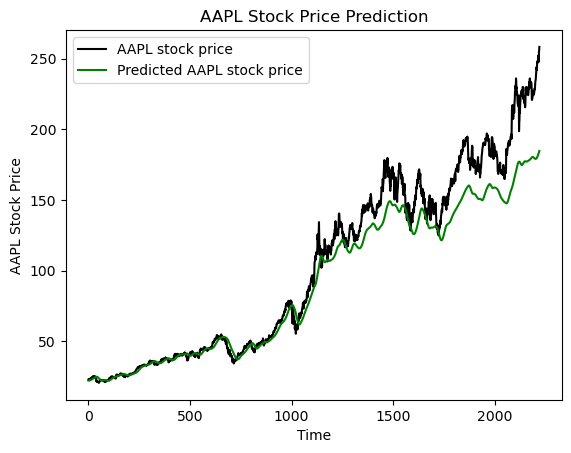

AAPL_stock_plot_lstm.png


In [8]:
import os

plt.plot(y_truth, color = 'black', label = f'{ticker} stock price')
plt.plot(predicted_stock_price, color = 'green', label = f'Predicted {ticker} stock price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()

image_path = os.path.join(f'{ticker}_stock_plot_lstm.png')

plt.savefig(image_path)
plt.show()
plt.close()
print(image_path)


In [9]:
from sklearn.metrics import r2_score
r2 = r2_score(y_truth, predicted_stock_price)
print(r2)

0.9127191243516353
